In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from spmf import Spmf
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import ast
pd.options.plotting.backend = "plotly"
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.subplots as sp
pd.options.display.max_colwidth = None
pd.set_option('display.max_rows', 70)
from pandas.plotting import table 
import nltk
import seaborn as sns
%matplotlib inline
import random
import matplotlib.gridspec as grid
import matplotlib
from sklearn.decomposition import NMF

# Loading data

In [2]:
data=pd.read_csv("sorted_coded_session_293s_merged.csv")
data['start']=data.groupby('user_id').session.shift(1)!=data.session
data['end']=data.groupby('user_id').session.shift(-1)!=data.session
data=data.drop(columns=['time_spend','app_code','sequence_number','sequence_Start_time','sequence_end_time'])

In [3]:
data=data.merge(data.groupby(['user_id','session']).agg({'package_name':'size'}).rename(columns={'package_name':'session_length'}).reset_index(),on=['user_id','session'])
data=data[data.session_length>1]

In [5]:
df_transition=pd.read_csv("individual_transition_matrices_min_length_2.csv")

In [9]:
df_transition[df_transition['next_app']=='start']

Empty DataFrame
Columns: [user_id, package_name, next_app, probability]
Index: []

In [27]:
df_transition[df_transition['next_app']=='end']

user_id                 package_name next_app  probability
15              0           bbc.mobile.weather      end     0.288660
45              0        bg.abv.andro.emailapp      end     0.226087
47              0                com.acobot.en      end     0.500000
69              0             com.adobe.reader      end     0.359375
70              0     com.alibaba.aliexpresshd      end     1.000000
...           ...                          ...      ...          ...
10728005     9999                  com.ubercab      end     0.285714
10728039     9999                 com.whatsapp      end     0.268879
10728052     9999                uk.co.ee.myee      end     0.437500
10728059     9999    uk.co.nationalrail.google      end     0.100000
10728077     9999  uk.co.santander.santanderUK      end     0.195122

[647274 rows x 4 columns]

The transition probability is rescaled to represent probility instead of percentage.

In [ ]:
#data without sessions of length one
# for nmf data with clusters : include session of length one? data=pd.read_csv("names_with_app_clusters.csv")
#this does include sessions of length one,but NaN values are not included, so transitions to "end" is not part of this. 

In [141]:
# Have previously been run to rescale from percentage to probability.
#df_transition['probability']=df_transition.probability/100
#df_transition=df_transition.drop('Unnamed: 0',axis=1)
#df_transition.to_csv("individual_transition_matrices_min_length_2.csv",index=False)

# Illustration
The earlier illustraion trying to highlight the highest transition probabilities was confusing. Here we therefore try other approaches to see if they give a better overview.

## Top 10 probabilites
In this section we try to highlight the top 10 highest transition proabilities for a subset of users. However first we must filter out packages which only occure ones, as they automaticly obtain a misleading 100 percent transition proability.

In [10]:
df_transition_without_ones=df_transition[df_transition.package_name.isin(data.groupby('package_name').size()[data.groupby('package_name').size()>1].index)]

Now the 10 transitions with the highest transition probability is found for each user.

In [11]:
top_10_individual_transitions=df_transition_without_ones.loc[df_transition_without_ones.groupby(['user_id']).probability.nlargest(10,keep='first').reset_index().level_1.values]

In [12]:
top_10_individual_transitions=top_10_individual_transitions.set_index('user_id')

In [13]:
random.seed(3)
users=random.sample(range(0, 10000),k=20)

In [17]:
top_10_individual_transitions['transition']=top_10_individual_transitions.package_name+' -> '+top_10_individual_transitions.next_app

We test if any transitions occur multiple times in the top 10 of the 20 user.

In [18]:
df_top10s=pd.DataFrame()
for i in range(20):
    df_top10s=df_top10s.append(top_10_individual_transitions.loc[users[i]])

In [19]:
df_top10s.groupby('transition').size()[df_top10s.groupby('transition').size()>1]

transition
com.google.android.apps.plus -> com.android.chrome                            2
com.instagram.boomerang -> com.instagram.android                              2
com.sonymobile.android.addoncamera.styleportrait -> com.sonyericsson.album    2
dtype: int64

We see that it is only very few transitions which occur more than once of the top 10s. One of the transitions which found to occur in more than one of the top 10s is com.instagram.boomerang -> com.instagram.android. These two have a bulid in connection as the boomerang app, was build by instgram to be used with instagram. We now test if such connections are often found between apps with high transition probability. To do so we identify the developer of each starting app (for the transition) through the common patter *com.developer. ...*. Having identified the devloper, we check if the developer is mention in the end app (of the transition). This is done on the full version of the top 10s, where if more than 10 transitions have a transition probability belonging to top 10, they are also included.

In [21]:
complete_top_10_individual_transitions=df_transition_without_ones.loc[df_transition_without_ones.groupby(['user_id']).probability.nlargest(10,keep='all').reset_index().level_1.values]

In [22]:
complete_top_10_individual_transitions['developer']=complete_top_10_individual_transitions.package_name.str.extract(r'(com\.[^.]*[\.]?)')#\.[^.]*')#.groupby('transition').size()[df_top10s.groupby('transition').size()>1]

In [23]:
print('number of apps were developer is not identified',len(complete_top_10_individual_transitions[(complete_top_10_individual_transitions['developer'].isnull())].package_name.unique()))
complete_top_10_individual_transitions[(complete_top_10_individual_transitions['developer'].isnull())]

number of apps were developer is not identified 4511


user_id                    package_name  \
773             0              flv.mobile.android   
774             0               net.zedge.android   
776             0  uk.co.bbc.android.iplayerradio   
801             1             bbc.iplayer.android   
2548            1         ie.slice.mylottoireland   
...           ...                             ...   
10725583     9996            net.mugcat.everychat   
10725593     9996                net.surprisechat   
10727214     9998               de.mini.connected   
10727215     9998                   kr.aboy.tools   
10727288     9999          air.nn.mobile.app.main   

                                   next_app  probability developer  
773                      com.android.chrome     1.000000       NaN  
774       com.google.android.apps.translate     1.000000       NaN  
776                                     end     1.000000       NaN  
801                     com.facebook.katana     1.000000       NaN  
2548                     com.android.chrome     1.000000       NaN  
...                                     ...          ...       ...  
10725583     com.google.android.apps.photos     1.000000       NaN  
10725593    com.chatter.stranger.video.chat     1.000000       NaN  
10727214                                end     1.000000       NaN  
10727215               com.sonymobile.email     1.000000       NaN  
10727288                                end     0.666667       NaN  

[24930 rows x 5 columns]

We see that a large number of apps does not follow the classical pattern for identifying the developer. These are exclude to investigate the more general connection, but could contain connections between the apps in the transitions, on a developer level.

In [28]:
complete_top_10_individual_transitions_without_null=complete_top_10_individual_transitions[complete_top_10_individual_transitions['developer'].isnull().apply(lambda l:not l)]
complete_top_10_individual_transitions_without_null[[x[0] in x[1] for x in zip(complete_top_10_individual_transitions_without_null.developer, complete_top_10_individual_transitions_without_null.next_app)]]

user_id                                          package_name  \
1902            1                                  com.instagram.layout   
4752            5                                com.sonyericsson.video   
5251            6                                com.sonyericsson.video   
5003            6                         com.firstgroup.first.mtickets   
5753            7                              com.google.android.music   
...           ...                                                   ...   
10720461     9992                                com.google.android.tts   
10721868     9993  com.sonymobile.androidapp.cameraaddon.stickercreator   
10726688     9998                             com.google.android.street   
10727923     9999                                  com.sonyericsson.xhs   
10727698     9999                                  com.instagram.layout   

                                         next_app  probability  \
1902                        com.instagram.android     1.000000   
4752                       com.sonyericsson.album     0.500000   
5251                       com.sonyericsson.album     1.000000   
5003                     com.firstgroup.first.bus     0.800000   
5753      com.google.android.googlequicksearchbox     1.000000   
...                                           ...          ...   
10720461                   com.google.android.gms     1.000000   
10721868                    com.sonymobile.sketch     1.000000   
10726688             com.google.android.apps.maps     1.000000   
10727923           com.sonyericsson.conversations     1.000000   
10727698                    com.instagram.android     0.666667   

                  developer  
1902         com.instagram.  
4752      com.sonyericsson.  
5251      com.sonyericsson.  
5003        com.firstgroup.  
5753            com.google.  
...                     ...  
10720461        com.google.  
10721868    com.sonymobile.  
10726688        com.google.  
10727923  com.sonyericsson.  
10727698     com.instagram.  

[9670 rows x 5 columns]

In [113]:
complete_top_10_individual_transitions_without_null[[x[0] in x[1] for x in zip(complete_top_10_individual_transitions_without_null.developer, complete_top_10_individual_transitions_without_null.next_app)]].shape[0]/complete_top_10_individual_transitions_without_null.shape[0]

0.06280158725004384

We see that the number of transition between same developer apps, are not that high in the complete top 10s.

To see if some transitions are very common accross users we look at the complete top 10s for all users.

In [29]:
complete_top_10_individual_transitions=df_transition_without_ones.loc[df_transition_without_ones.groupby(['user_id']).probability.nlargest(10,keep='all').reset_index().level_1.values]

In [45]:
complete_top_10_individual_transitions['transition']=complete_top_10_individual_transitions.package_name+' -> '+complete_top_10_individual_transitions.next_app

In [51]:
complete_top_10_individual_transitions.groupby('transition').size().nlargest(20,keep='all')

transition
com.sonymobile.android.addoncamera.styleportrait -> com.sonyericsson.album    1202
com.sonymobile.xperiaweather -> com.android.chrome                             663
com.sonymobile.sketch -> end                                                   422
com.bitstrips.imoji -> com.snapchat.android                                    413
com.sonyericsson.music -> end                                                  389
com.google.android.music -> end                                                370
com.sonymobile.androidapp.cameraaddon.areffect -> end                          361
com.sonymobile.sketch -> com.sonyericsson.album                                353
com.sonyericsson.trackid -> end                                                345
com.sonymobile.getmore.client -> end                                           322
com.google.android.play.games -> end                                           320
com.google.android.googlequicksearchbox -> com.android.chrome               

In [ ]:
#run only to save result to csv
#complete_top_10_individual_transitions.groupby('transition').size().nlargest(20,keep='all').to_csv("20transition_that_occur_in_most_top10s.csv")

## Top five most frequent apps

As an alternative way to visualise the individual users behaviour a subsection of their transition matrix, containing the transitions between the five most frequent app for the user, is shown.\
The data set used for callculating the individual app frequency does not include sessions of length one.

In [71]:
data_individual_app_count = data.groupby(['user_id','package_name'])\
                            .agg({'session':'size'})\
                            .rename(columns={'session':'app_count'})

In [72]:
top_5_apps=data_individual_app_count.reset_index().loc[data_individual_app_count.reset_index().groupby('user_id').app_count.nlargest(5).reset_index().level_1.values].groupby('user_id')

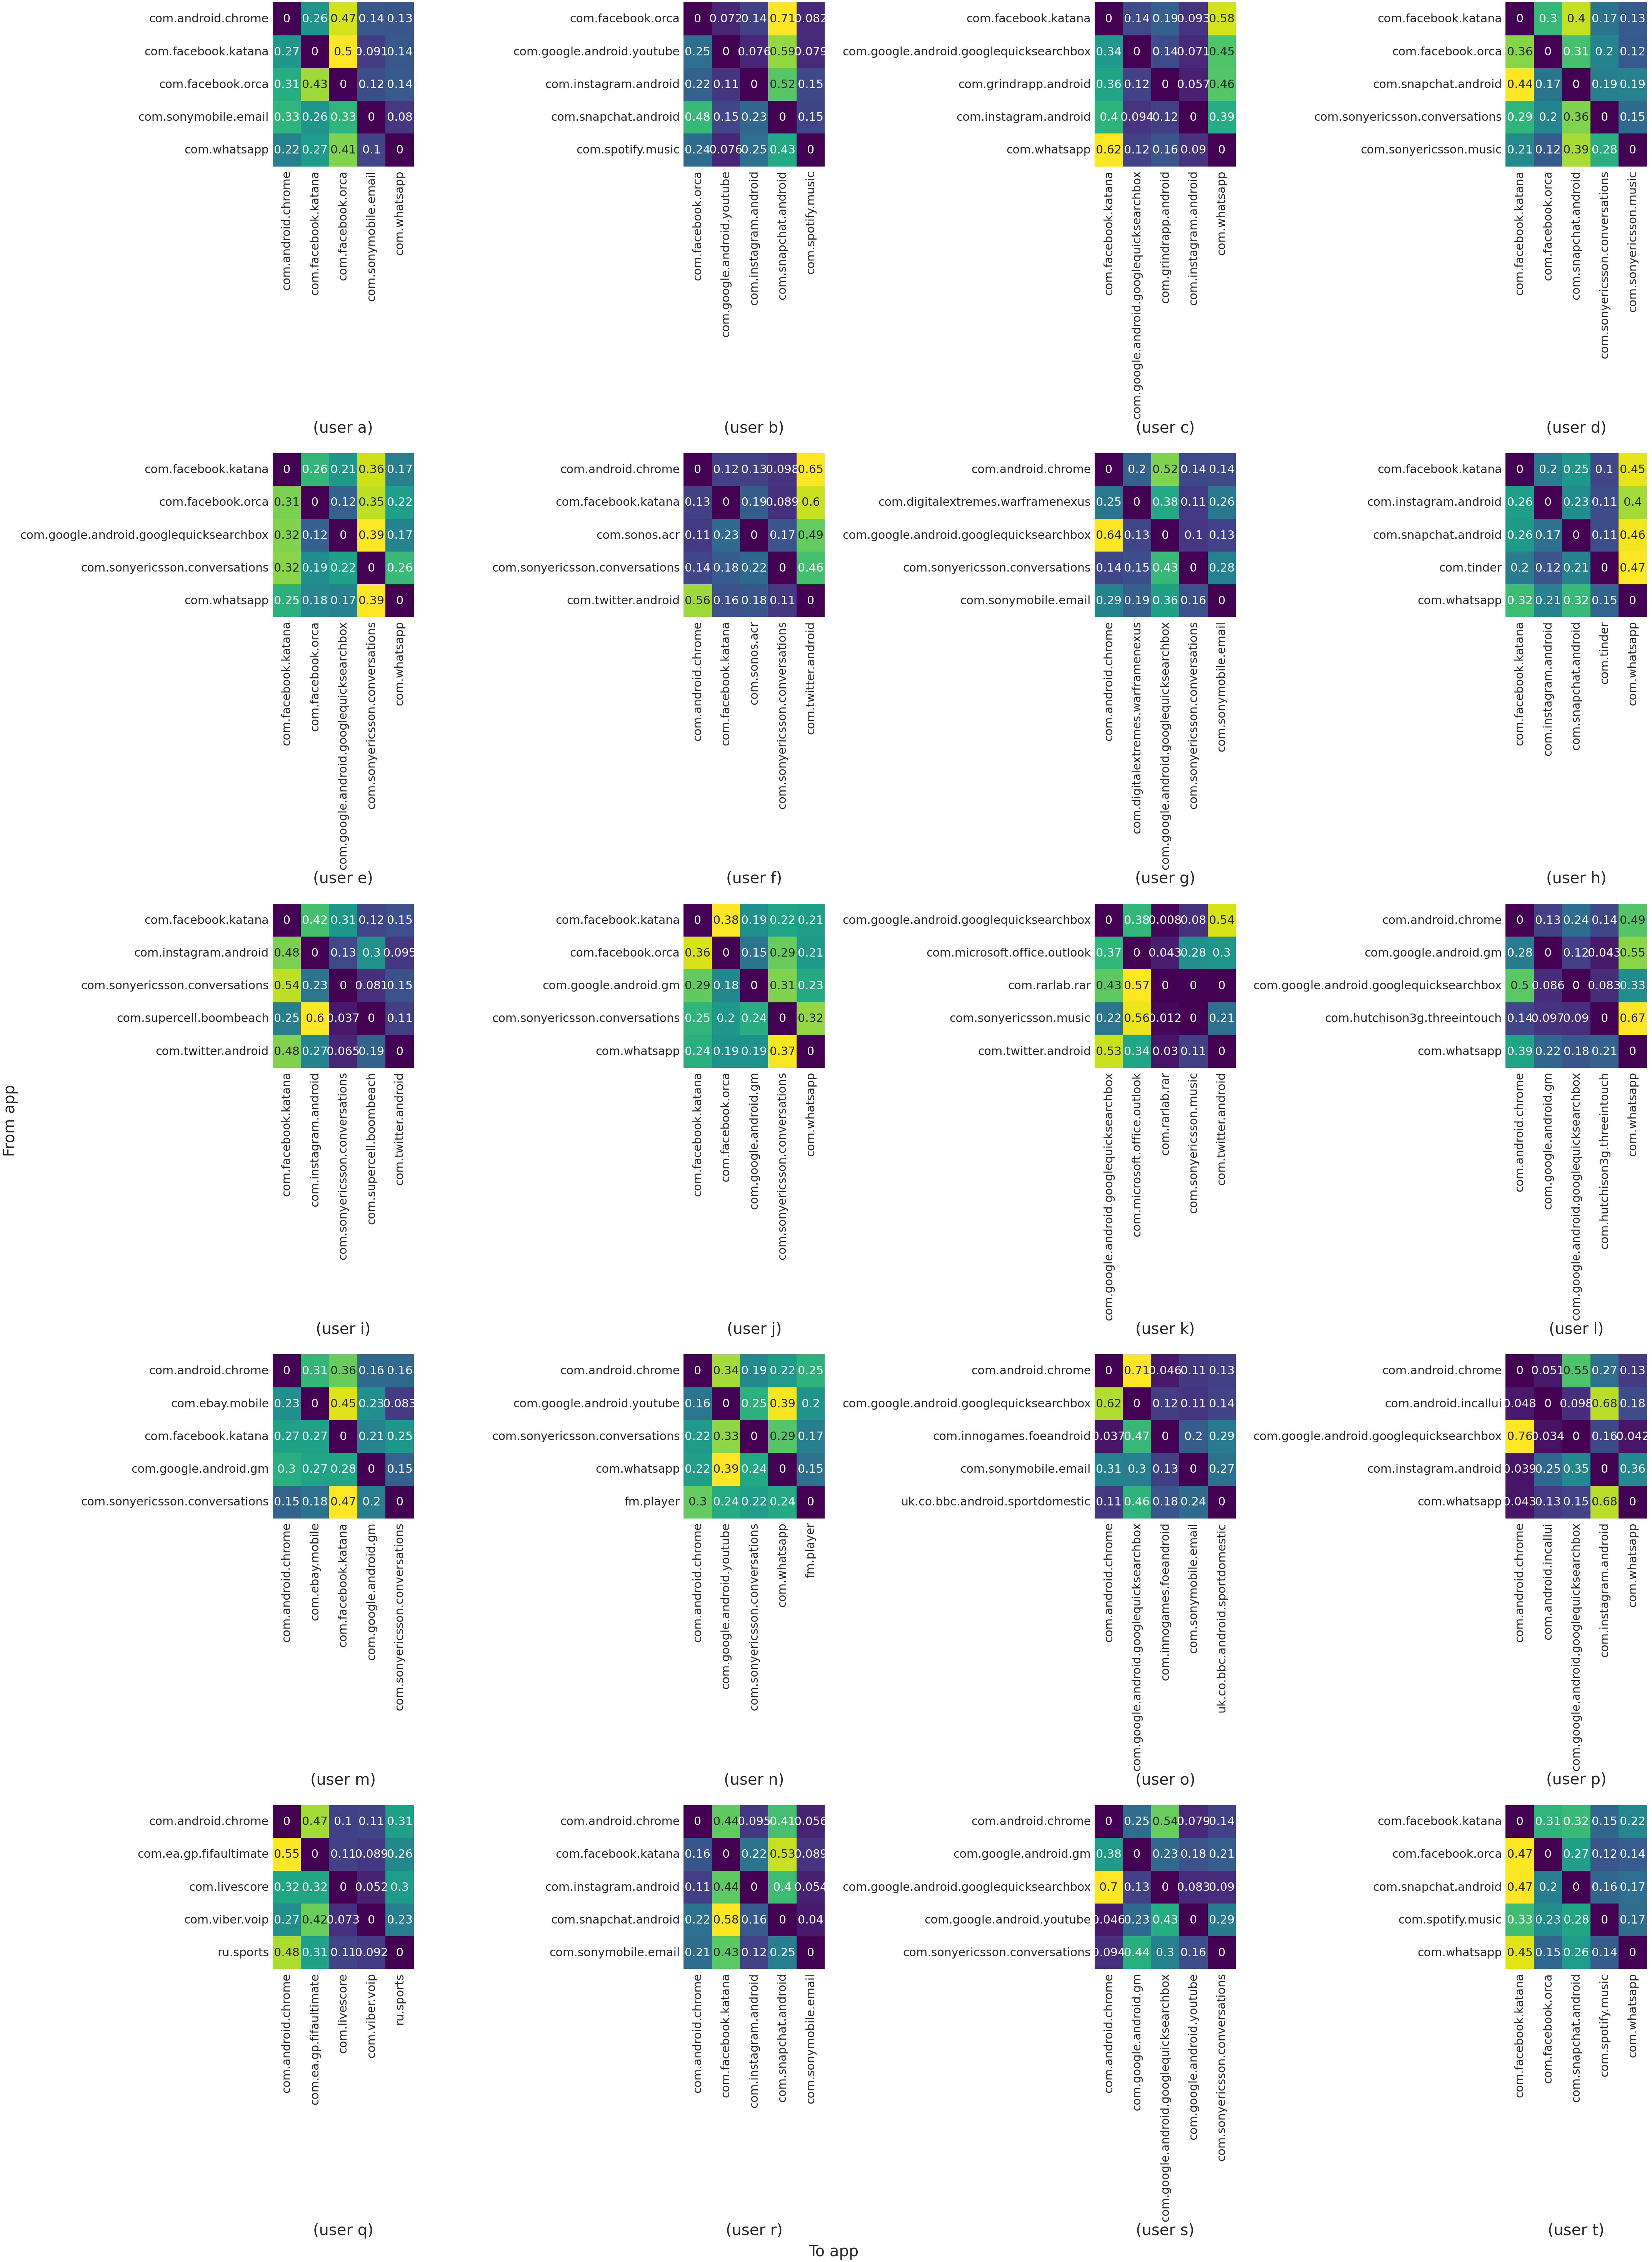

In [95]:
import string
fig, axs = plt.subplots(5,4,figsize=(60,82))  
axs = axs.ravel()
for i in range(20):
    sns.set(font_scale=1.9)
    transitions_for_top_5=df_transition[(df_transition.package_name.isin(top_5_apps.get_group(users[i]).package_name))&(df_transition.next_app.isin(top_5_apps.get_group(users[i]).package_name))]  
    transitions_for_top_5=transitions_for_top_5[transitions_for_top_5.user_id==users[i]]
    transitions_for_top_5['probability']=transitions_for_top_5[transitions_for_top_5.user_id==users[i]].groupby('package_name').probability.transform(lambda x: x  / x.sum())
    sns.heatmap(transitions_for_top_5.pivot(index=['package_name'], columns="next_app", values="probability").fillna(0), cmap=sns.color_palette("viridis", as_cmap=True),annot=True,ax=axs[i],cbar=False,annot_kws={"fontsize":30}) 
    axs[i].set_ylabel('')    
    axs[i].set_xlabel('')
    axs[i].set_xlabel("(user {})".format(string.ascii_lowercase[i]),size=40)
    axs[i].tick_params(axis='both', which='major', labelsize=30)
fig.align_labels() 
fig.tight_layout(pad=2)
fig.text(0.5, 0, 'To app', ha='center',size=40)
fig.text(0, 0.5, 'From app', va='center', rotation='vertical',size=40)
plt.savefig("individual_trancistion_matrices_top5.pdf", 
               bbox_inches='tight', 
               transparent=True,
               pad_inches=0)
plt.show()

In [108]:
df_top_5_apps=pd.DataFrame()
for i in range(20):
    df_top_5_apps=df_top_5_apps.append(top_5_apps.get_group(users[i]))

In [122]:
print("Number of user for which the app is one of the five most used")
df_top_5_apps.groupby('package_name').size().sort_values(ascending=False)

Number of user for which the app is one of the five most used


package_name
com.android.chrome                         11
com.facebook.katana                        11
com.whatsapp                                9
com.sonyericsson.conversations              9
com.google.android.googlequicksearchbox     8
com.facebook.orca                           6
com.instagram.android                       6
com.snapchat.android                        5
com.sonymobile.email                        4
com.google.android.gm                       4
com.twitter.android                         3
com.google.android.youtube                  3
com.spotify.music                           2
com.sonyericsson.music                      2
com.tinder                                  1
com.viber.voip                              1
com.supercell.boombeach                     1
fm.player                                   1
ru.sports                                   1
com.microsoft.office.outlook                1
com.sonos.acr                               1
com.rarlab.rar       

We see that many of the apps, which are among the top 5 most used for the 20 users, many of them are well known apps, that occur for serveral of the users.\
The highest transitions varies alot for the users, however a strong connection between chrome and google is indicated.

In [149]:
df_transitions_for_top5=pd.DataFrame()
for i in range(20):
    transitions_for_top_5=df_transition[(df_transition.package_name.isin(top_5_apps.get_group(users[i]).package_name))&(df_transition.next_app.isin(top_5_apps.get_group(users[i]).package_name))]  
    transitions_for_top_5=transitions_for_top_5[transitions_for_top_5.user_id==users[i]]
    transitions_for_top_5['probability']=transitions_for_top_5[transitions_for_top_5.user_id==users[i]].groupby('package_name').probability.transform(lambda x: x  / x.sum())
    df_transitions_for_top5=df_transitions_for_top5.append(transitions_for_top_5)

In [159]:
df_transitions_for_top5['rank']=df_transitions_for_top5.groupby('user_id').probability.rank(ascending=False)

In [161]:
df_transitions_for_top5[(df_transitions_for_top5.package_name=='com.android.chrome')&(df_transitions_for_top5.next_app=='com.google.android.googlequicksearchbox')]

user_id        package_name                                 next_app  \
8364626     7766  com.android.chrome  com.google.android.googlequicksearchbox   
8282788     7687  com.android.chrome  com.google.android.googlequicksearchbox   
4145248     3839  com.android.chrome  com.google.android.googlequicksearchbox   
3394913     3141  com.android.chrome  com.google.android.googlequicksearchbox   
9668878     9005  com.android.chrome  com.google.android.googlequicksearchbox   

         probability  rank  
8364626     0.516874   2.0  
8282788     0.238342   8.0  
4145248     0.706107   1.0  
3394913     0.547107   4.0  
9668878     0.538462   2.0

In [162]:
df_transitions_for_top5[(df_transitions_for_top5.next_app=='com.android.chrome')&(df_transitions_for_top5.package_name=='com.google.android.googlequicksearchbox')]

user_id                             package_name            next_app  \
8365887     7766  com.google.android.googlequicksearchbox  com.android.chrome   
8283028     7687  com.google.android.googlequicksearchbox  com.android.chrome   
4145474     3839  com.google.android.googlequicksearchbox  com.android.chrome   
3395202     3141  com.google.android.googlequicksearchbox  com.android.chrome   
9669156     9005  com.google.android.googlequicksearchbox  com.android.chrome   

         probability  rank  
8365887     0.640572   1.0  
8283028     0.501650   3.0  
4145474     0.622332   2.0  
3395202     0.759664   1.0  
9669156     0.696517   1.0

An alternative illustration, with unified colormap for all users, is created below. However it is in this version harder to identify the transitions that stands out for each user.

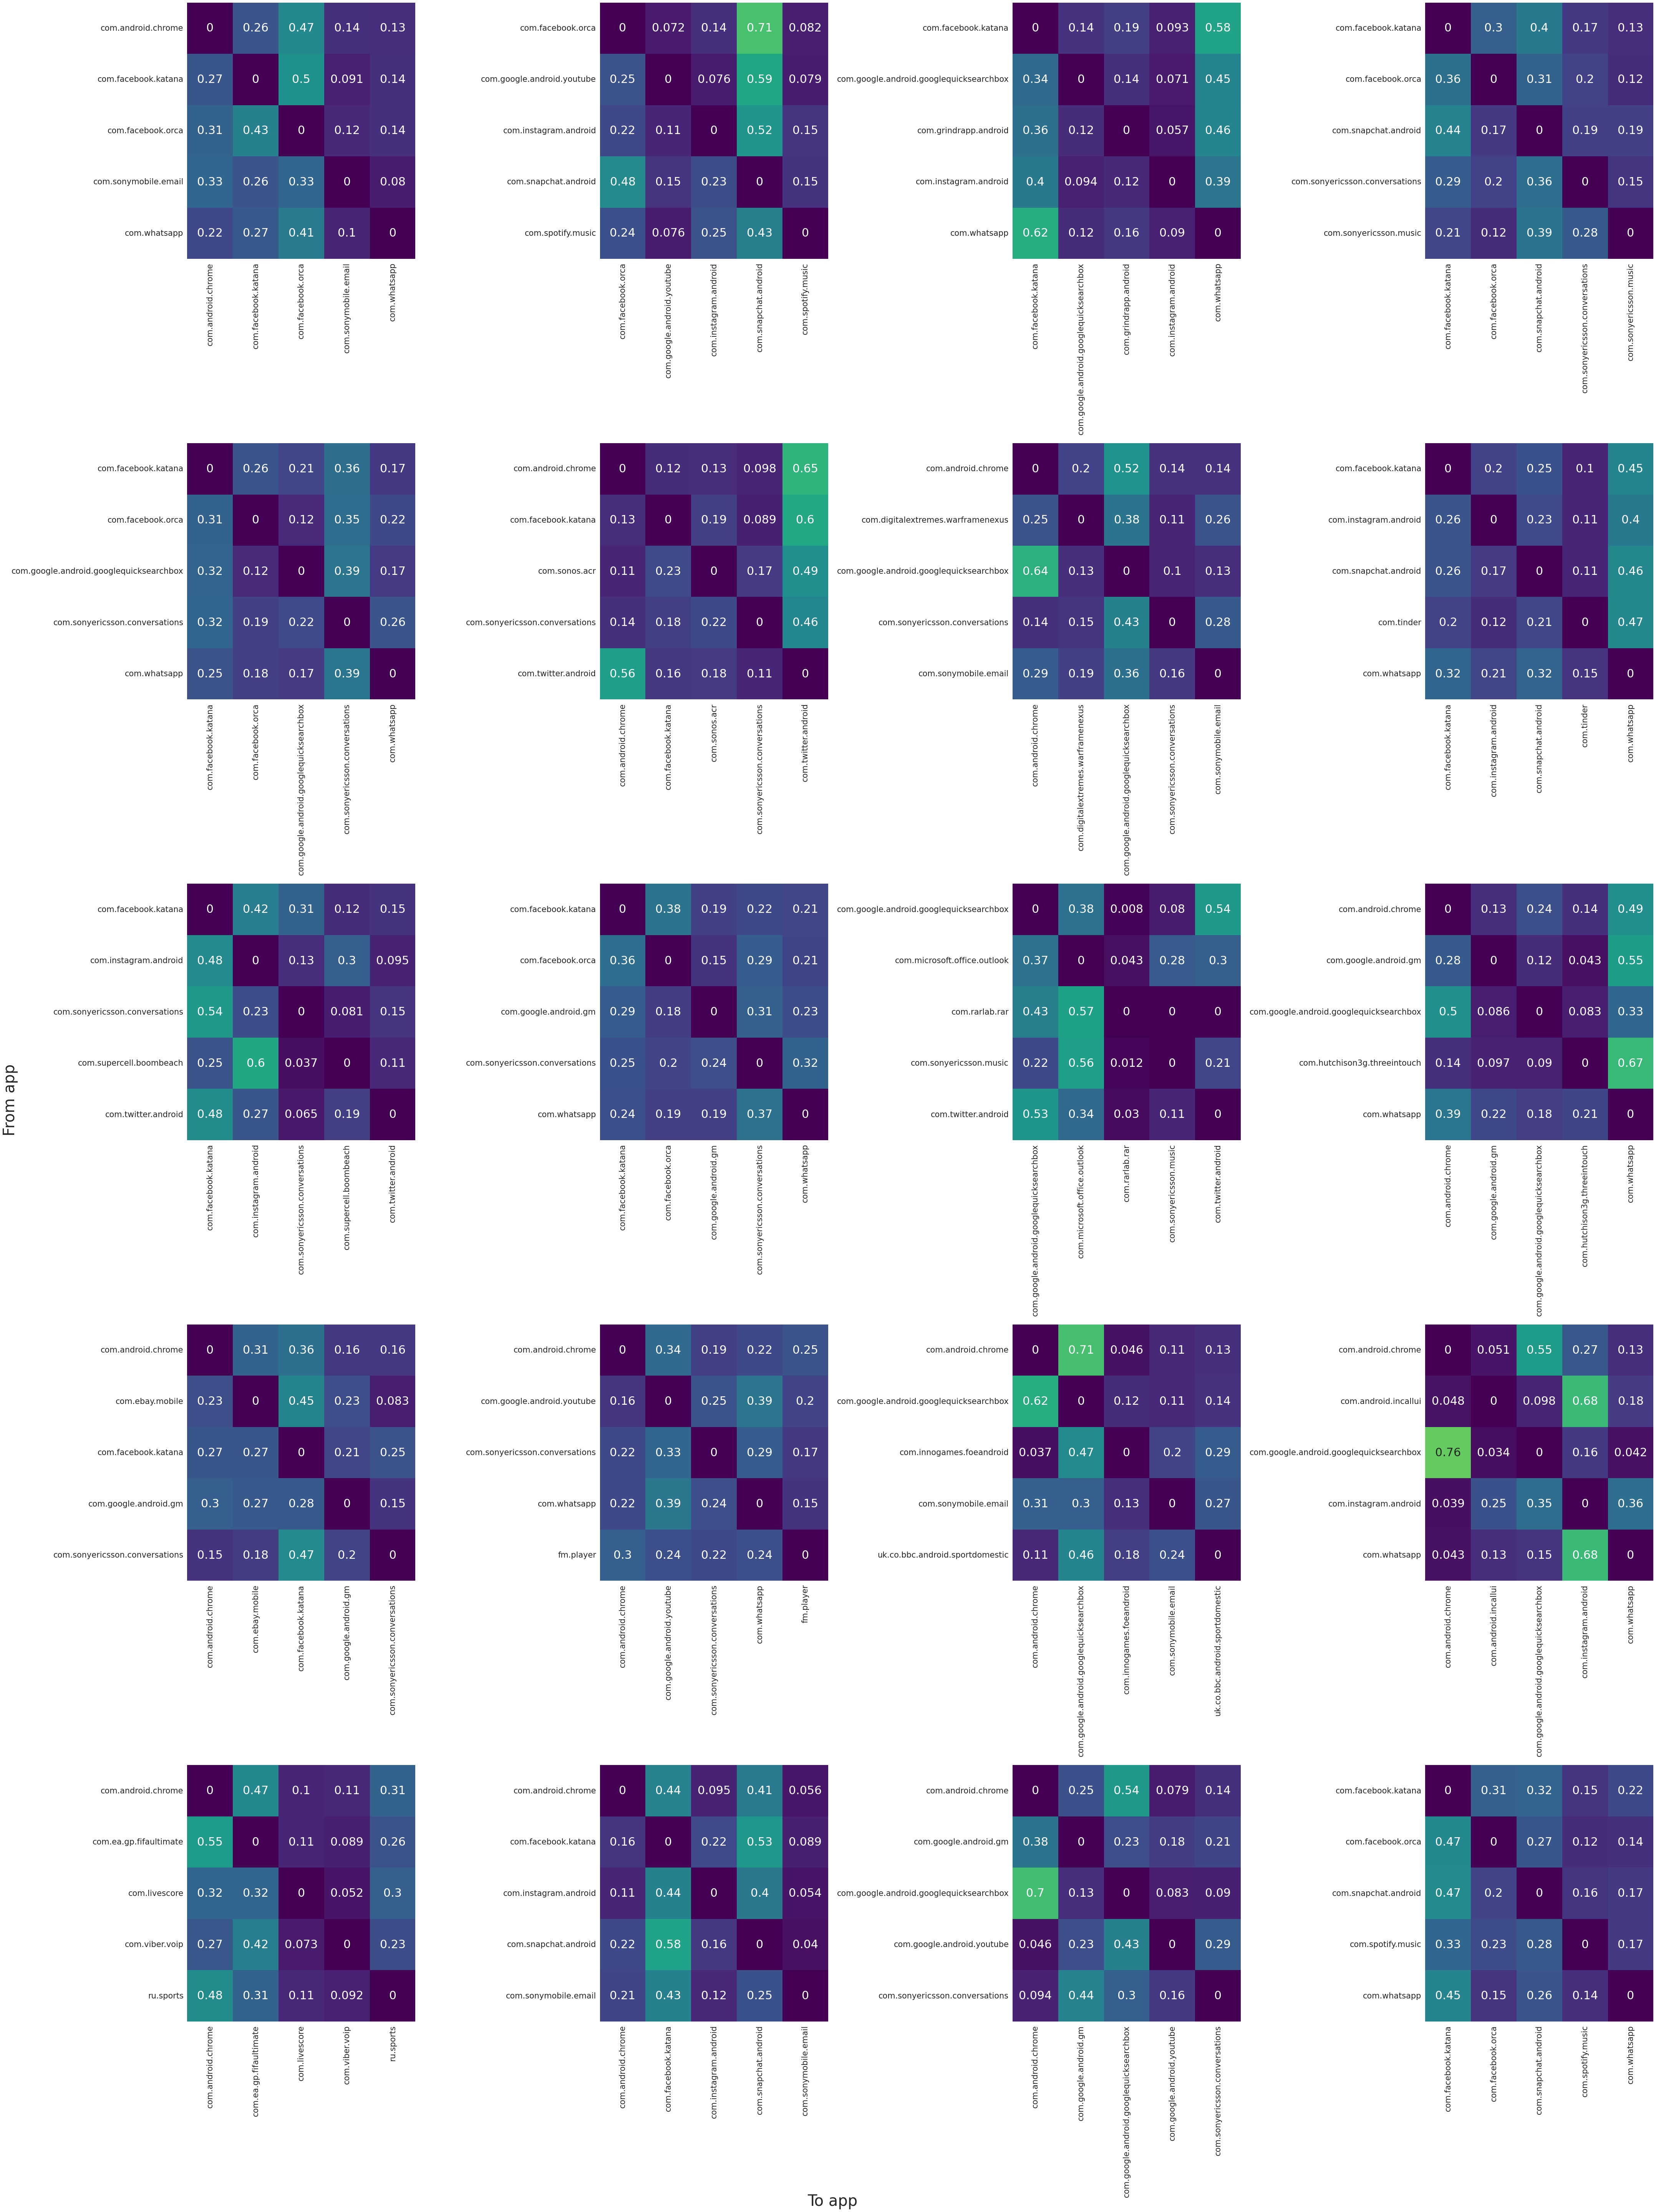

In [41]:
fig, axs = plt.subplots(5,4,figsize=(60,80))  
axs = axs.ravel()
for i in range(20):
    sns.set(font_scale=1.9)
    transitions_for_top_5=df_transition[(df_transition.package_name.isin(top_5_apps.get_group(users[i]).package_name))&(df_transition.next_app.isin(top_5_apps.get_group(users[i]).package_name))]  
    transitions_for_top_5=transitions_for_top_5[transitions_for_top_5.user_id==users[i]]
    transitions_for_top_5['probability']=transitions_for_top_5[transitions_for_top_5.user_id==users[i]].groupby('package_name').probability.transform(lambda x: x  / x.sum())
    im=sns.heatmap(transitions_for_top_5.pivot(index=['package_name'], columns="next_app", values="probability").fillna(0), cmap=sns.color_palette("viridis", as_cmap=True),vmin=0,vmax=1,annot=True,ax=axs[i],cbar=False,annot_kws={"fontsize":30}) 
    axs[i].set_ylabel('')    
    axs[i].set_xlabel('')
fig.tight_layout(pad=1)
fig.text(0.5, 0, 'To app', ha='center',size=40)
fig.text(0, 0.5, 'From app', va='center', rotation='vertical',size=40)
plt.savefig("individual_trancistion_matrices_top5_rainbow.pdf", 
               bbox_inches='tight', 
               transparent=True,
               pad_inches=1)
plt.show()